In [ ]:
# Imports
import h5py
import numpy as np
import matplotlib.pyplot as plt

## Exploring the Data

Loading one of the data files downloaded and checking the datasets available

In [ ]:
file_path0 = 'data/MJD_Train_0.hdf5'

with h5py.File(file_path0, 'r') as f:
    print('Datasets available in the file: ')
    for key in f.keys():
        print(key)

Datasets available in the file: 
detector
energy_label
id
psd_label_dcr
psd_label_high_avse
psd_label_low_avse
psd_label_lq
raw_waveform
run_number
tp0


Graph out one random waveform and check whether the labels are satisfied.

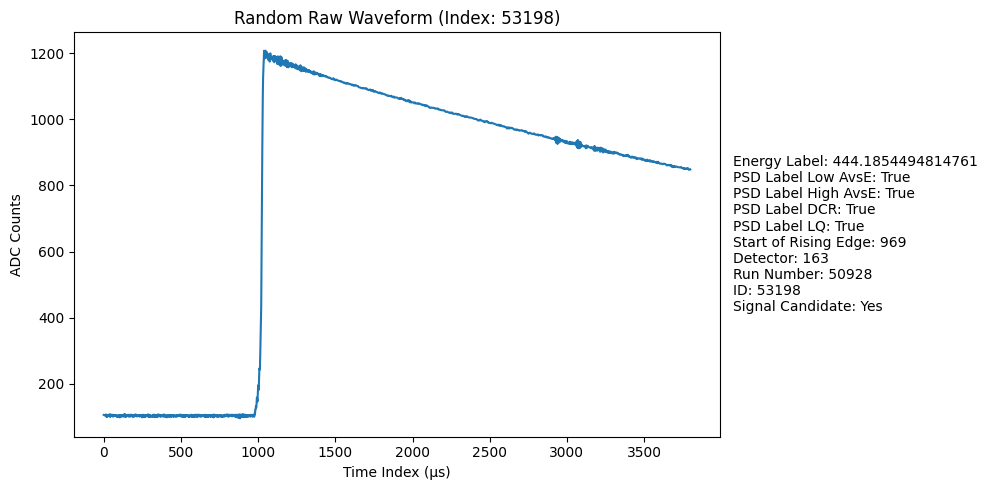

In [ ]:
with h5py.File(file_path0, 'r') as f:
    # Load Waveform
    raw_waveform = np.array(f['raw_waveform'])
    
    # Load Labels
    energy_label = np.array(f['energy_label'])
    psd_label_low_avse = np.array(f['psd_label_low_avse'])
    psd_label_high_avse = np.array(f['psd_label_high_avse'])
    psd_label_dcr = np.array(f['psd_label_dcr'])
    psd_label_lq = np.array(f['psd_label_lq'])
    tp0 = np.array(f['tp0'])
    detector = np.array(f['detector'])
    run_number = np.array(f['run_number'])
    id = np.array(f['id'])

    # Get Index
    idx = np.random.choice(raw_waveform.shape[0])

    # Index Waveform
    idx_waveform = raw_waveform[idx]

    # Index Labels
    energy_value = energy_label[idx]
    psd_low_avse_value = psd_label_low_avse[idx]
    psd_high_avse_value = psd_label_high_avse[idx]
    psd_dcr_value = psd_label_dcr[idx]
    psd_lq_value = psd_label_lq[idx]
    tp0_value = tp0[idx]
    detector_value = detector[idx]
    run_number_value = run_number[idx]
    id_value = id[idx]

    # Determine Signal Candidate
    # energy_threshold = 0
    is_signal_candidate = (
        # energy_value > energy_threshold and
        psd_low_avse_value and
        psd_high_avse_value and
        psd_dcr_value and
        psd_lq_value
    )

    
    # Plot Figure
    plt.figure(figsize=(10, 5))
    plt.plot(idx_waveform)
    plt.title(f"Random Raw Waveform (Index: {id_value})")
    plt.xlabel("Time Index (µs)")
    plt.ylabel("ADC Counts")

    # Display Labels
    label_text = (
        f"Energy Label: {energy_value}\n"
        f"PSD Label Low AvsE: {'True' if psd_low_avse_value else 'False'}\n"
        f"PSD Label High AvsE: {'True' if psd_high_avse_value else 'False'}\n"
        f"PSD Label DCR: {'True' if psd_dcr_value else 'False'}\n"
        f"PSD Label LQ: {'True' if psd_lq_value else 'False'}\n"
        f"Start of Rising Edge: {tp0_value}\n"
        f"Detector: {detector_value}\n"
        f"Run Number: {run_number_value}\n"
        f"ID: {id_value}\n"
    )
    plt.text(1.02, 0.5, label_text, transform=plt.gca().transAxes, verticalalignment='center')
    plt.tight_layout()
    plt.show()


As we can see from

## Parameter Extraction

Creating a function for tdrift50, that is time indices between the start oft he rise and 50% of the rise.

We assume that all waveforms start to rise at time index 1000. Although this assumption should be correct for most waveforms in the data, we should figure out a better way to determine when the rise starts perhaps using the gradients of the slope. 

In [7]:
def get_tdrift50(waveform, start_idx = 1000):
    # Find the index of the peak value
    max_idx = np.argmax(waveform)

    # Calculate the middle y-value (50%) between start and max
    start_y = waveform[start_idx]
    max_y = waveform[max_idx]
    mid_y = (start_y + max_y) / 2

    # Find the x-value (index) where the waveform crosses the middle y-value
    mid_x_idx = start_idx + np.argmax(waveform[start_idx:max_idx] >= mid_y)

    tdrift50 = mid_x_idx - start_idx 

    ## print(f" Start X value: {start_idx}\n",f"50% X value: {mid_x_idx}\n",f"tdrift50: {tdrift50}\n")

    return int(tdrift50)

In [8]:
idx = np.random.choice(raw_waveform.shape[0])
idx_waveform = raw_waveform[idx]

get_tdrift50(idx_waveform)

18

Another parameter we are planning on extracting is the Delayed Charge Recovery parameter which is measured by the area above the tail slope after the peak.

In [ ]:
peak_idx = np.argmax(idx_waveform)
peak_val = int(idx_waveform[peak_idx])
data_after_peak = idx_waveform[peak_idx:]
time_indices = np.arange(peak_idx, len(idx_waveform))
area_above_tail_slope = np.trapezoid(peak_val - data_after_peak, x=time_indices) 

print("Peak value:", peak_val)
print("Area above the curve after the peak:", area_above_tail_slope)

Peak value: 691
Area above the curve after the peak: 287873.375


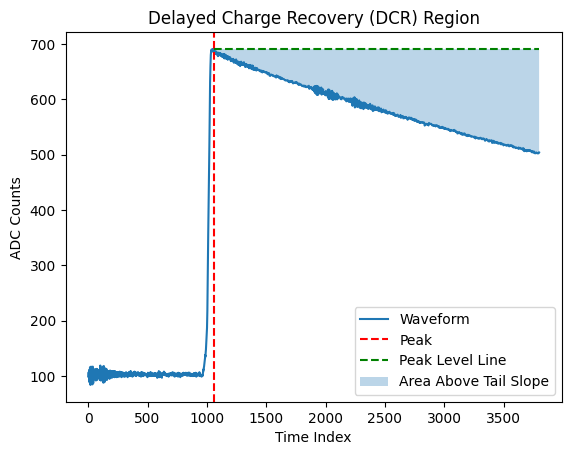

In [10]:
plt.plot(idx_waveform, label="Waveform")
plt.axvline(x=peak_idx, color='r', linestyle='--', label="Peak")
plt.hlines(peak_val, peak_idx, len(idx_waveform)-1, colors='g', linestyles='--', label="Peak Level Line")
plt.fill_between(time_indices, data_after_peak, peak_val, where=(data_after_peak < peak_val),
                 alpha=0.3, label="Area Above Tail Slope")
plt.xlabel("Time Index")
plt.ylabel("ADC Counts")
plt.legend()
plt.title("Delayed Charge Recovery (DCR) Region")
plt.show()

Here I have plotted a visual of the area calculated.

Now we create a general function to calculate the DCR for any waveform.

In [11]:
def find_dcr(waveform):

    # Find peak index value
    peak_idx = np.argmax(waveform)

    # Find peak value
    peak_val = int(waveform[peak_idx])

    # We are only looking at the data after the peak
    data_after_peak = waveform[peak_idx:]

    # Get all time indices between peak and end of the time series
    time_indices = np.arange(peak_idx, len(waveform))

    # Calculate DCR region
    area_above_tail_slope = np.trapezoid(peak_val - data_after_peak, x=time_indices) 
    
    return area_above_tail_slope

Here the parameter functions are being applied to several different files.

In [12]:
files = [
    "MJD_Train_1.hdf5",
    "MJD_Train_2.hdf5",
    "MJD_Train_3.hdf5",
    "MJD_Train_4.hdf5"
]

Some waveforms in the data did not start its rise at index 1000, for these waveforms I chose to ignore and skip them for now but I may come back later to normalize my data just ot make sure every waveform rises at the same index.

In [14]:
for file_path in files:
    with h5py.File("data/" + file_path, 'r') as f:
        tdrift50_sum = 0
        dcr_sum = 0
        tdrift50_squared_sum = 0
        dcr_squared_sum = 0
        num_waveforms = 0

        raw_waveforms = np.array(f['raw_waveform'])

        for waveform in raw_waveforms:

            max_idx = np.argmax(waveform)
            
            # Skip waveform is it does not satisfy our conditions
            if waveform.size == 0:
                continue
            if 1000 >= len(waveform) or 1000 >= max_idx:
                continue

            # Calculate tdrift50 and DCR for the current waveform
            tdrift50 = get_tdrift50(waveform)
            dcr = find_dcr(waveform)

            # Accumulate sums for averages
            tdrift50_sum += tdrift50
            dcr_sum += dcr

            # Accumulate squared sums for MSE calculation
            tdrift50_squared_sum += tdrift50 ** 2
            dcr_squared_sum += dcr ** 2

            # Count waveforms
            num_waveforms += 1

        tdrift50_avg = tdrift50_sum / num_waveforms
        dcr_avg = dcr_sum / num_waveforms

        tdrift50_mse = (tdrift50_squared_sum / num_waveforms) - (tdrift50_avg ** 2)
        dcr_mse = (dcr_squared_sum / num_waveforms) - (dcr_avg ** 2)

        # Output the results
        print("Current File:", file_path)
        print("tdrift50 Average:", tdrift50_avg)
        # print("tdrift50 MSE:", tdrift50_mse)
        print("DCR Average:", dcr_avg)
        # print("DCR MSE:", dcr_mse)
        print("Number of Valid Waveforms in File:", num_waveforms)
        print("\n")


Current File: MJD_Train_1.hdf5
tdrift50 Average: 26.817876716546586
DCR Average: 744773.0910914696
Number of Valid Waveforms in File: 64956


Current File: MJD_Train_2.hdf5
tdrift50 Average: 26.82231595800363
DCR Average: 751692.5256940061
Number of Valid Waveforms in File: 64958


Current File: MJD_Train_3.hdf5
tdrift50 Average: 26.61278357496845
DCR Average: 753726.0061245653
Number of Valid Waveforms in File: 64974


Current File: MJD_Train_4.hdf5
tdrift50 Average: 26.879718578730216
DCR Average: 748720.5308165335
Number of Valid Waveforms in File: 64956


